In [1]:
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
from datetime import datetime
import re
import numpy as np
import time
import nltk
import wordninja
from matplotlib.colors import ListedColormap

In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/punyajoy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
threshold={'hatespeech':0.8,'fearspeech':0.7,'normal':0.7}
dict_labels={'hatespeech':2,'fearspeech':1,'normal':0}
reverse_dict_labels={dict_labels[key]:key for key in dict_labels.keys()}

In [4]:
dict_posts={}

In [5]:
import pickle5 as pickle
#files = sorted(glob('../../Gab_Data/new_features/gab_fear_hate_features*.pickle'))
files = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))


reposted_normal=[]

for file in tqdm_notebook(files,total=len(files)):
    with open(file, 'rb') as handle:
        Gab_keyword_match = pickle.load(handle)
        
    if('predicted_probab' not in Gab_keyword_match[1].keys()):
        continue
        
    for element in Gab_keyword_match:
        
        post={}
        
        try:
            dt = datetime.fromisoformat(element['post_create_time'])
        except KeyError:
            continue
        
        
        try:
            post['id']=element['id']
            post['body']=element['post_body']
            post['date']=dt
        except KeyError:
            continue
  
        
        if(dict_repost[element['id']]!=[]):
            repost_dicts=dict_repost[element['id']]
            count_normal=0
            count=0
            for repost_element in repost_dicts:
                try:
                    temp=all_normal_dict[repost_element['reposter_username']]
                    count_normal+=1
                except KeyError:
                    count+=1
                    pass
            if(count_normal>0):
                reposted_normal.append(count_normal)
        
        labels=[]
        
        
        for i in range(len(element['predicted_probab'])):        
            if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                labels.append(reverse_dict_labels[i])
        
        if('fearspeech' in labels):
            post['labels']='fearspeech'
            dict_posts[post['id']]=post
        elif('hatespeech' in labels):
            post['labels']='hatespeech'
            dict_posts[post['id']]=post
        else:
            pass
    
    #print("datasets loaded")
    
    


/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/212 [00:00<?, ?it/s]

NameError: name 'dict_repost' is not defined

In [ ]:
np.mean(reposted_normal)

In [ ]:
len(dict_posts)

In [ ]:
df=pd.DataFrame(dict_posts).transpose().reset_index(drop=True)

In [ ]:
df.to_csv('Text_timestamp.csv',index=False)


## Start of LDA 

In [4]:
df=pd.read_csv('Text_timestamp.csv')
#df = pd.read_csv('Text_timestamp_new.csv',index_col=False)

In [5]:
df_fear=df[df['labels']=='fearspeech']
df_hate=df[df['labels']=='hatespeech']

In [6]:
df['labels'].value_counts()

hatespeech    709158
fearspeech    426455
Name: labels, dtype: int64

In [7]:
import pyLDAvis


In [8]:
def cleaner(tweet):
    tweet = tweet.lower()
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet_preprocess=[]
    for word in tweet.split(" "):
        try:
            if(word[0]=='#'):
                tweet_preprocess.append(" ".join(wordninja.split(word)))
            else:
                tweet_preprocess.append(word)
        except:
            tweet_preprocess.append(word)
            
    tweet_preprocess= " ".join(tweet_preprocess)
    tweet_preprocess= " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet_preprocess).split())
    
    return tweet_preprocess

df_fear['preprocessed'] = df_fear['body'].map(lambda x: cleaner(x))
df_hate['preprocessed'] = df_hate['body'].map(lambda x: cleaner(x))

<>:16: DeprecationWarning: invalid escape sequence \w
<>:16: DeprecationWarning: invalid escape sequence \w
<>:16: DeprecationWarning: invalid escape sequence \w
<ipython-input-8-345b6a338424>:16: DeprecationWarning: invalid escape sequence \w
  tweet_preprocess= " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet_preprocess).split())
/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [9]:
# def lemmatize_stemming(text):
#     stemmer = SnowballStemmer('english')
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append((token))
    return result

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def get_variables(df_temp):
    processed_docs = df_temp['preprocessed'].map(preprocess)
    dictionary =  gensim.corpora.Dictionary(processed_docs)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    return bow_corpus,dictionary,processed_docs
    

In [10]:
bow_corpus_fear,dictionary_fear,processed_docs_fear=get_variables(df_fear)
bow_corpus_hate,dictionary_hate,processed_docs_hate=get_variables(df_hate)


In [10]:
from gensim.models import CoherenceModel
from gensim import corpora
# id2word = corpora.Dictionary(processed_docs)
#coherence_scores = []

for topic in [60,65,70,75]:
    print("Num_topic: ",topic)
    lda_model = gensim.models.LdaMulticore(bow_corpus_fear, num_topics=topic,random_state=2022,id2word=dictionary_fear, passes=5, workers=20)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs_fear, dictionary=dictionary_fear, coherence='c_npmi')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)
    print('Coherence Score: ', coherence_lda)
    

Num_topic:  60


NameError: name 'bow_corpus_fear' is not defined

In [ ]:
coherence_scores

In [ ]:
import matplotlib.pyplot as plt
topics = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
plt.plot(topics, coherence_scores,'go--', linewidth=2, markersize=5)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence Score v/s Number of topics')
plt.savefig('../Results/coherence_fear.pdf')

# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
from gensim.models import CoherenceModel
from gensim import corpora
coherence_scores = []

for topic in [5,10,15,20,25,30,35,40]:
    print("Num_topic: ",topic)
    lda_model = gensim.models.LdaMulticore(bow_corpus_hate, num_topics=topic, random_state=2022, id2word=dictionary_hate, passes=20, workers=20)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs_hate, dictionary=dictionary_hate, coherence='c_npmi')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)
    print('Coherence Score: ', coherence_lda)
    

In [ ]:
import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = (6, 6)

topics = [5,10,15,20,25,30]
plt.plot(topics, coherence_scores[:-2],'go--', linewidth=2, markersize=5)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence Score v/s Number of topics')
plt.savefig('../Results/coherence_hate.pdf')

# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

In [16]:
import datetime
from dateutil import parser


In [11]:
from gensim.models import CoherenceModel
from gensim import corpora
lda_model_fear = gensim.models.LdaMulticore(bow_corpus_fear, num_topics=15, random_state=2022, id2word=dictionary_fear, passes=10, workers=20)

In [12]:
lda_model_hate = gensim.models.LdaMulticore(bow_corpus_hate, num_topics=15, random_state=2022, id2word=dictionary_hate, passes=20, workers=20)

In [35]:
dict_topics_fear={0:'Jews control media',
             1:'illegal immigration in europe',
             2:'Arab,jews harming children',
             3:'illegal immigration in USA',
             4:'violence by Muslim community',
             5:'left and Islam conspiracy',
             6:'white genocide in south africa',
             7:'Muslims raping white women',
             8:'Islam ideology dangerous',
             9:'immigration destroying culture',
             10:'refugees from Syrians',
             11:'immigrants manipulating election',
             12:'America needs to wake up',
             13:'Jews controlling internet',
             14:'illegal immigrants taking jobs'
            }


dict_topics_fear_words={}

for index in range(0,15):
    list_words=[lda_model_fear.id2word[word[0]] for word in lda_model_fear.get_topic_terms(index, topn=20)]
    dict_topics_fear_words[dict_topics_fear[index]]=list_words

In [38]:
import pickle
with open('../Results/topic_words_fear.pickle', 'wb') as handle:
    pickle.dump(dict_topics_fear_words, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [20]:
def predict_lda(df,lda_model,id2word):
    predicted_topics=[]
    for index,row in tqdm_notebook(df.iterrows(),total=len(df)):
        text = preprocess(row['preprocessed'])
        text = id2word.doc2bow(text)
        predicted_topics.append(max(lda_model[text],key=lambda item:item[1])[0])
    return predicted_topics
    


In [21]:
predicted_topics = predict_lda(df_fear,lda_model_fear,dictionary_fear)
df_fear['topics']=predicted_topics

/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/426455 [00:00<?, ?it/s]

/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
predicted_topics = predict_lda(df_hate,lda_model_hate,dictionary_hate)
df_hate['topics']=predicted_topics

/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/709158 [00:00<?, ?it/s]

/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
dict_topics_fear={0:'Jews control media',
             1:'illegal immigration in europe',
             2:'Arab,jews harming children',
             3:'illegal immigration in USA',
             4:'violence by Muslim community',
             5:'left and Islam conspiracy',
             6:'white genocide in south africa',
             7:'Muslims raping white women',
             8:'Islam ideology dangerous',
             9:'immigration destroying culture',
             10:'refugees from Syrians',
             11:'immigrants manipulating election',
             12:'America needs to wake up',
             13:'Jews controlling internet',
             14:'illegal immigrants taking jobs'
            }



dict_topics_hate={0:'multitarget insults',
             1:'insults about Africans',
             2:'insults about Muslims',
             3:'insults about Jews',
             4:'insults about homosexuals',
             5:'dehumanising women',
             6:'hate against party supporters, voters',
             7:'hate against communists and liberals',
             8:'insults against Canadians',
             9:'deport illegal immigrants',
             10:'blaming Africans for everything',
             11:'insulting women of other community',
             12:'targeting Muslim and homosexual people',
             13:'supporting nazi and insulting jews',
             14:'women projected as prostitutes'
            }


def get_topic_distribution(df_text,threshold,dict_topics_names):
    
    with open('../Results/dict_per_date.json', 'r') as openfile:
        # Reading from json file
        dict_per_date = json.load(openfile)

    
    topic_dist={}
    freq_month={}
    for index,row in tqdm_notebook(df_text.iterrows(),total=len(df_text)):
        timestamp=parser.parse(row['date'])
        month_year_str=str(timestamp.month)+'-'+str(timestamp.year)
        try:
            topic_dist[row['topics']][month_year_str]+=1
        except KeyError:
            try:
                topic_dist[row['topics']][month_year_str]=1
            except KeyError:
                topic_dist[row['topics']]={}
                topic_dist[row['topics']][month_year_str]=1

        try:
            freq_month[month_year_str]+=1
        except KeyError:
            freq_month[month_year_str]=1
    
    #### Sorted topic dist
    
    sorted_topic_dist={}
    
    
    for topic_num in topic_dist:
        keys = list(topic_dist[topic_num].keys())
        keys.sort(key=lambda x: datetime.datetime.strptime(x,'%m-%Y'))
        dict_temp={}
        for key in keys:
            try:
                sorted_topic_dist[key][topic_num]=topic_dist[topic_num][key]
            except KeyError:
                sorted_topic_dist[key]={}
                sorted_topic_dist[key][topic_num]=topic_dist[topic_num][key]
    
        
    dict_filter={}
    for key in sorted_topic_dist.keys():
        #normal_count=dict_per_date['/'.join(key.split('-'))]['total']
        normal_count=freq_month[key]
        
        count_dist_sort={k: v/normal_count for k, v in sorted(sorted_topic_dist[key].items(), key=lambda item: item[1],reverse=True)}
        dict_filter[key]=count_dist_sort
    
    df=pd.DataFrame(dict_filter).T
    df=df.fillna(0)
    return df

In [24]:
df_fear['topics']=df_fear['topics'].map(dict_topics_fear)
df_hate['topics']=df_hate['topics'].map(dict_topics_hate)

/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Prevalence

In [25]:
df_hate['topics'].value_counts()

hate against party supporters, voters     68440
dehumanising women                        63573
insults about Jews                        62750
deport illegal immigrants                 62056
women projected as prostitutes            57822
supporting nazi and insulting jews        55386
multitarget insults                       53436
hate against communists and liberals      47629
insults about Africans                    44991
insults about Muslims                     41828
insulting women of other community        39671
insults about homosexuals                 32113
blaming Africans for everything           30516
targeting Muslim and homosexual people    28801
insults against Canadians                 20146
Name: topics, dtype: int64

In [26]:
df_fear['topics'].value_counts()

America needs to wake up            58911
violence by Muslim community        42725
Islam ideology dangerous            41180
Jews control media                  39030
illegal immigrants taking jobs      33208
illegal immigration in europe       29892
white genocide in south africa      28380
left and Islam conspiracy           26669
Muslims raping white women          26096
Jews controlling internet           25854
illegal immigration in USA          20705
Arab,jews harming children          19080
refugees from Syrians               15360
immigrants manipulating election    15076
immigration destroying culture       4289
Name: topics, dtype: int64

In [27]:
list(df_fear[df_fear['topics']=='jews controlling internet'].sample(10)['body'])

ValueError: a must be greater than 0 unless no samples are taken

In [28]:
list(df_hate[df_hate['topics']=='insults about africans'].sample(10)['body'])

ValueError: a must be greater than 0 unless no samples are taken

In [29]:
list(df_hate.sample(10)['body'])

['MUZRAT cook who refuses to use toilet paper?',
 '@ZephyrRhino hes a freaking pig!!',
 'Hurry up and die shit-stain, I want to finish my meme.',
 "De Blasio is umber than a box of rocks.\xa0 This cuban nigger lover wants to be president some day but he can't run a porta potty.",
 'Being a nigger and a cry baby is the now time.',
 "so far today ...I have pissed in Susan Wojcicki's corn flakes, memed the fuck out antifa, shit posted cnn...twice, and put a baby in a black woman's ass to mock, the breast feeding while having sex, lady.\nI am going to be kicked off twitter soon.",
 'Not surprised by the names especially traitor and songbird McCain. He should be in prison for the rest of his miserable lying life #arrestmccain',
 "Bring it! I'd love for your ass to be sitting in jail! ",
 'Just for the official record, though, the half-breed alien faggot is NOT a mudslime! He IS a Communist satan worshipper; & claims to any other religion by, or about him, are incorrect information, or outri

In [31]:
df_normalise_fear=get_topic_distribution(df_fear,10,list(dict_topics_fear.values()))

/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/426455 [00:00<?, ?it/s]

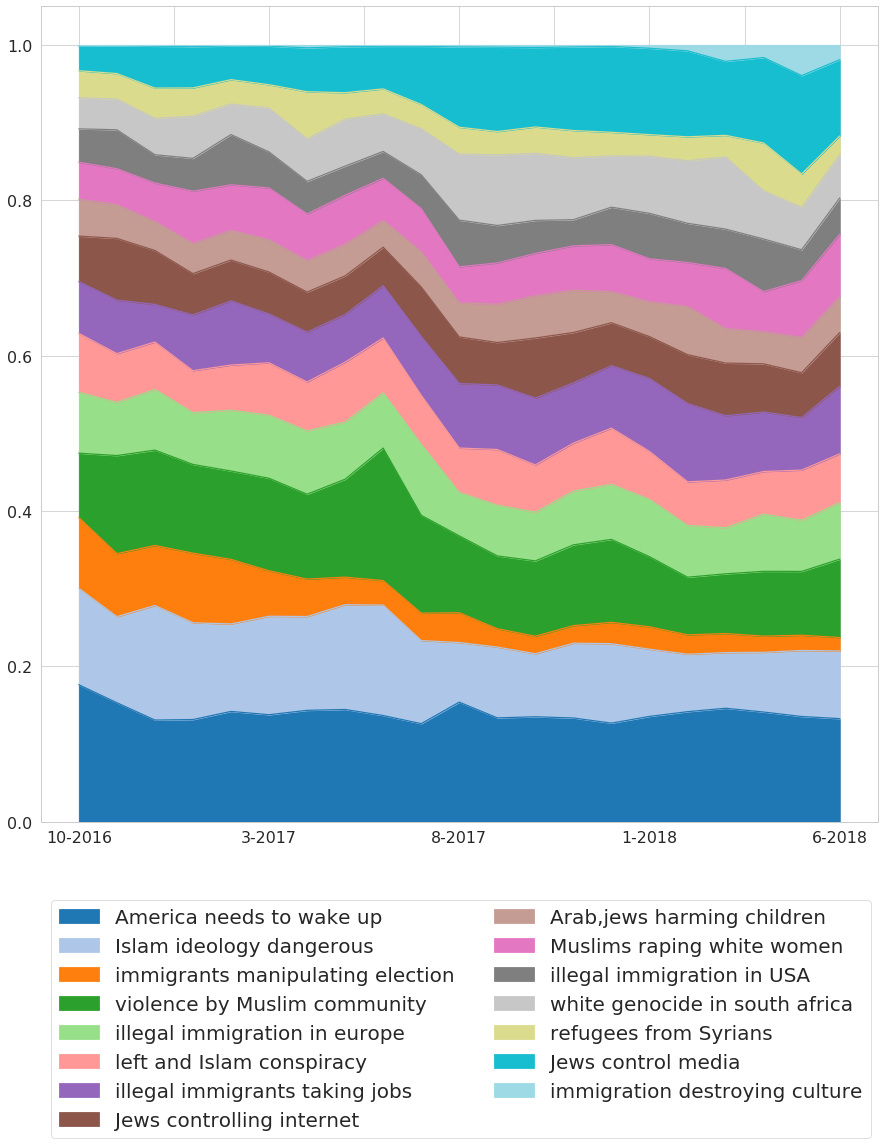

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 15)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
sns.set(context='paper',style='whitegrid',font_scale=1.8)
df_normalise_fear.plot(kind='area', stacked=True,colormap='tab20')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, -0.4),ncol=2,prop={'size': 20,'weight':'medium'})
path='../Results/temporal_topic_fear.pdf'
plt.savefig(path,bbox_inches='tight',dpi=500)

In [33]:
len(df_normalise_fear.columns)

15

In [34]:
df_normalise_hate=get_topic_distribution(df_hate,10,dict_topics_hate)

/home/punyajoy/.conda/envs/multimodal/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/709158 [00:00<?, ?it/s]

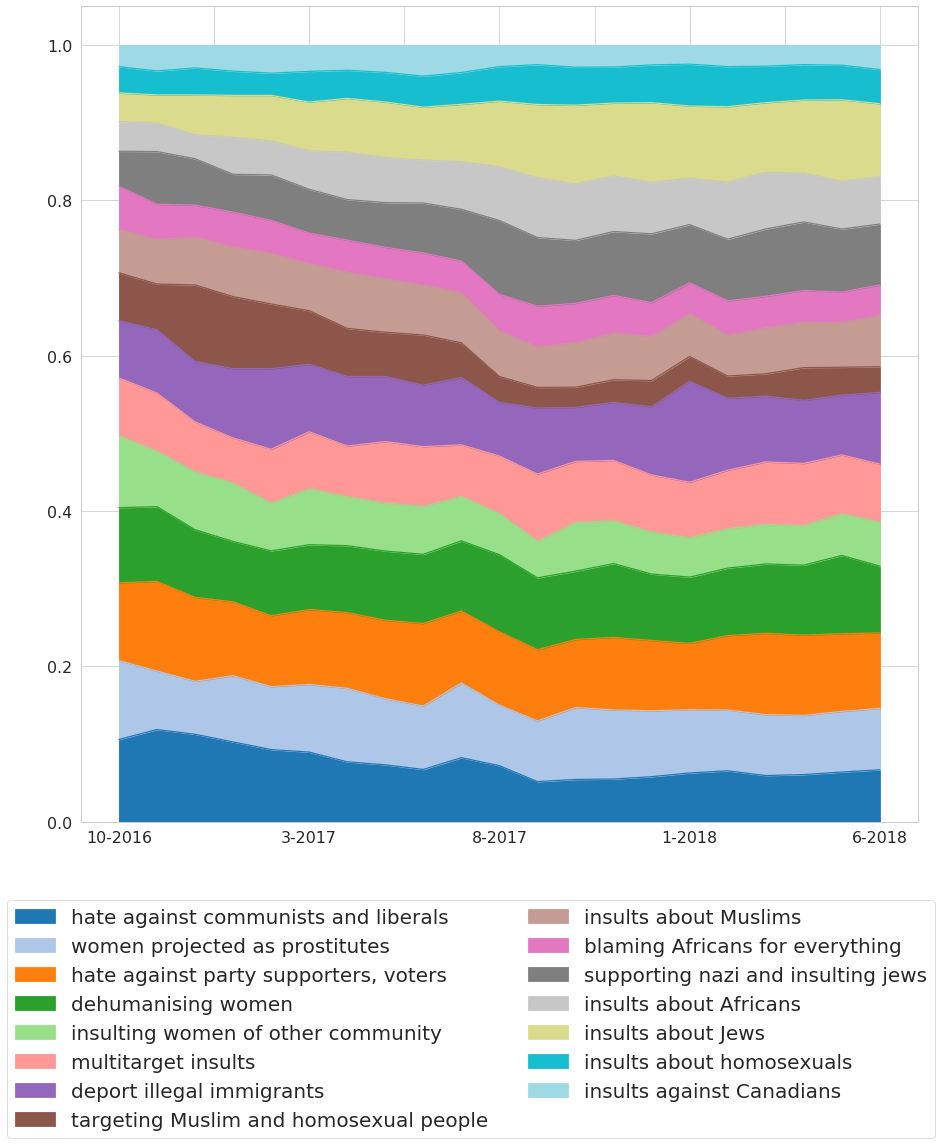

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 15)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
sns.set(context='paper',style='whitegrid',font_scale=1.8)
df_normalise_hate.plot(kind='area', stacked=True,colormap='tab20')
plt.legend(loc="lower left", bbox_to_anchor=(-0.1, -0.4),ncol=2,prop={'size': 20,'weight':'medium'})
path='../Results/temporal_topic_hate.pdf'
plt.savefig(path,bbox_inches='tight',dpi=500)

In [ ]:
for i in sorted(range(15)):
    topic_word_tuples=lda_model_hate.show_topic(i, topn=15)
    sent= ", ".join([ele[0] for ele in topic_word_tuples])
    str1= str(i)+" & "+sent+"\\\\hline"
    print(str1)

In [ ]:
df=pd.DataFrame(timeline_topic,columns=['topic_num','topics'])
df.to_latex(buf='my-table.tex',index=False)

In [ ]:
df_final = df_final.sort_index()
df_final

In [ ]:
df_final.to_csv("Text_timestamp_LDA.csv",index=False)

In [ ]:
df1 = pd.read_csv('Text_timestamp.csv')


In [ ]:
list(df1[df1['labels']=='fearspeech'].sample(5)['body'])

## End of LDA

In [ ]:
x = [(6, 0.058111865), (7, 0.4779809), (11, 0.266155), (12, 0.1488493)]
x

In [ ]:
max(x,key=lambda item:item[1])[0]

In [ ]:
#https://towardsdatascience.com/exploring-the-un-general-debates-with-dynamic-topic-models-72dc0e307696

In [ ]:
def cleaner(tweet):
    tweet = tweet.lower()
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet_preprocess=[]
    for word in tweet.split(" "):
        try:
            if(word[0]=='#'):
                tweet_preprocess.append(" ".join(wordninja.split(word)))
            else:
                tweet_preprocess.append(word)
        except:
            tweet_preprocess.append(word)
            
    tweet_preprocess= " ".join(tweet_preprocess)
    tweet_preprocess= " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet_preprocess).split())
    
    return tweet_preprocess

df_fear['preprocessed'] = df_fear['body'].map(lambda x: cleaner(x))
df_hate['preprocessed'] = df_hate['body'].map(lambda x: cleaner(x))


In [ ]:
import re
import pandas as pd
from datetime import datetime
# Filter
df_sample=df_hate
df_sample = df_sample.loc[(df_sample.preprocessed != ""), :]
timestamps = df_sample.date.to_list()
tweets = df_sample.preprocessed.to_list()

#### GetReposts

In [ ]:
import gzip
with gzip.open('../../../../Gab_Data/Reposts.pkl.gz','rb') as fp:
    dict_repost = pickle.load(fp)

In [ ]:
df_user_label=pd.read_csv('../Results/user_labelling.csv')
all_normal_dict={key:1 for key in list(df_user_label[df_user_label['label']=='normal']['user_key'])}


In [ ]:
df.labels.value_counts()

In [ ]:
def topic_reposted(df):
    topic_reposted={}
    topic_reposted_in_total={}
   
    user_reposted=[]
    for index,row in tqdm_notebook(df.iterrows(),total=len(df)):
        if(dict_repost[row['id']]!=[]):
            repost_dicts=dict_repost[row['id']]
            if(len(repost_dicts)!=0):
                try:
                    topic_reposted_in_total[row['topics']]+=1
                except KeyError:
                    topic_reposted_in_total[row['topics']]=1

            for element in repost_dicts:
                try:
                    temp=all_normal_dict[element['reposter_username']]
                    try:
                        topic_reposted[row['topics']]+=1
                    except KeyError:
                        topic_reposted[row['topics']]=1
            
                except KeyError:
                    user_reposted.append(element['reposter_username'])
                    pass
    
    for key in topic_reposted:
        topic_reposted[key]=topic_reposted[key]
    
    return topic_reposted

topic_reposted_fear=topic_reposted(df_fear)
topic_reposted_hate=topic_reposted(df_hate)




In [ ]:
import matplotlib.pyplot as plt

plt.bar(*zip(*topic_reposted_fear.items()),color='red')
plt.show()

In [ ]:
topic_reposted_hate

In [ ]:
np.mean(list(topic_reposted_hate.values()))

In [ ]:
import matplotlib.pyplot as plt

plt.bar(*zip(*topic_reposted_hate.items()),color='orange')
plt.show()

### Archived

In [ ]:
len(df_sample)

In [ ]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel


def calculate_coherence(tweets,topics,topic_model):
    documents = pd.DataFrame({"Document": tweets,
                              "ID": range(len(tweets)),
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
# coherence_scores=[]
from hdbscan import HDBSCAN
from umap import UMAP

In [ ]:
sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(tweets)

In [ ]:
# vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False,n_jobs=-1)
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True,core_dist_n_jobs=-1)
topic_model = BERTopic(min_topic_size=100,low_memory=False, calculate_probabilities=True,umap_model=umap_model,hdbscan_model=hdbscan_model,verbose=True)
# Prepare embeddings
topics, probs = topic_model.fit_transform(tweets)

In [ ]:
len(probs)

In [ ]:
new_topics = list(np.argmax(probs, axis=1)[0:])
temp_co=calculate_coherence(tweets,new_topics,topic_model)

In [ ]:
print("final coherence score",temp_co)

In [ ]:
df=pd.DataFrame(coherence_scores,columns=['topics','coherence_scores'])
df=df.sort_values(by='topics')
df.plot(x='topics',y='coherence_scores')
            

In [ ]:
freq =topic_model.get_topic_info() 

In [ ]:
topics_over_time = topic_model.topics_over_time(docs=tweets, 
                                                topics=new_topics, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=22)

In [ ]:
topics_over_time[0]

In [ ]:
topic_model.get_topic(8)

In [ ]:
topic_dist={}
freq_month={}
for index,row in tqdm_notebook(topics_over_time.iterrows(),total=len(topics_over_time)):
    month_year_str=str(row['Timestamp'].month)+'-'+str(row['Timestamp'].year)
    try:
        topic_dist[row['Topic']][month_year_str]+=row['Frequency']
    except KeyError:
        try:
            topic_dist[row['Topic']][month_year_str]=row['Frequency']
        except KeyError:
            topic_dist[row['Topic']]={}
            topic_dist[row['Topic']][month_year_str]=row['Frequency']
            
    try:
        freq_month[month_year_str]+=row['Frequency']
    except KeyError:
        freq_month[month_year_str]=row['Frequency']

In [ ]:
topic_dist[0].keys()

In [ ]:
count_dist={}
for key in topic_dist.keys():
    count=0
    for element in topic_dist[key].values():
        count+=element
    count_dist[key]=count

In [ ]:
for key in count_dist_sort:
    print(key,", ".join([key for key,value in topic_model.get_topic(key)]))
    print("========================")

In [ ]:
topic_elements=[]
for key in count_dist_sort:
    temp=[]
    for key_month in topic_dist[0].keys():
        try:
            temp.append(topic_dist[key][key_month])
        except KeyError:
            temp.append(0)
    topic_elements.append(temp)

In [ ]:
df=pd.DataFrame(topic_elements,columns=list(topic_dist[0].keys()))

In [ ]:
df.index=list(count_dist_sort.keys())

In [ ]:
df=df.T

In [ ]:
df_normalise=df.div(df.sum(axis=1), axis=0)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 10)
sns.set(context='paper',style='whitegrid',font_scale=1.5)
df_normalise.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
path='../Results/temporal_topic.pdf'
plt.savefig(path,bbox_inches='tight',dpi=400)

In [ ]:
fig=topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10,normalize_frequency=False)

In [ ]:
fig

In [ ]:
fig.write_image('../Results/fearspeech_temporal_topics.pdf')